In [0]:
import glob
import os
import music21
from music21 import *
import numpy as np
from music21 import converter, instrument, note, chord, duration, stream
import tensorflow as tf

print (music21.__version__) #if your version is lower than 4.x.x, you will encounter with some issues. 

5.5.0


In [0]:
# See figures inside jupyter notebook.
%matplotlib inline 

%config InlineBackend.figure_format = 'retina' # for Mac

# Prepossessing

In [0]:
def note_to_int(note): 
    # converts the note's letter to pitch value which is integer form.
    # source: https://musescore.org/en/plugin-development/note-pitch-values
    # idea: https://github.com/bspaans/python-mingus/blob/master/mingus/core/notes.py
    
    note_base_name = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    if ('#-' in note):
        first_letter = note[0]
        base_value = note_base_name.index(first_letter)
        octave = note[3]
        value = base_value + 12*(int(octave)-(-1))
        
    elif ('#' in note): 
        first_letter = note[0]
        base_value = note_base_name.index(first_letter)
        octave = note[2]
        value = base_value + 12*(int(octave)-(-1))
        
    elif ('-' in note): 
        first_letter = note[0]
        base_value = note_base_name.index(first_letter)
        octave = note[2]
        value = base_value + 12*(int(octave)-(-1))
        
    else:
        first_letter = note[0]
        base_val = note_base_name.index(first_letter)
        octave = note[1]
        value = base_val + 12*(int(octave)-(-1))
        
    return value

In [0]:
# Lets determine our matrix's value 
# rest --> (min_value, lower_bound)
# continuation --> (lower_bound, upper_bound)
# first_touch --> (upper_bound, max_value)

min_value = 0.00
lower_first = 0.00

lower_second = 0.5
upper_first = 0.5

upper_second = 1.0
max_value = 1.0

def notes_to_matrix(notes, durations, offsets, min_value=min_value, lower_first=lower_first,
                    lower_second=lower_second,
                    upper_first=upper_first, upper_second=upper_second,
                    max_value=max_value):
    
    # I want to represent my notes in matrix form. X axis will represent time, Y axis will represent pitch values.
    # I should normalize my matrix between 0 and 1.
    # So that I will represent rest with (min_value, lower_first), continuation with [lower_second, upper_first]
    # and first touch with (upper_second, max_value)
    # First touch means that you press the note and it cause to 1 time duration playing. Continuation
    # represent the continuum of this note playing. 
    
    try:
        last_offset = int(offsets[-1]) 
    except IndexError:
        print ('Index Error')
        return (None, None, None)
    
    total_offset_axis = last_offset * 4 + (8 * 4) 
    our_matrix = np.random.uniform(min_value, lower_first, (128, int(total_offset_axis))) 
    # creates matrix and fills with (-1, -0.3), this values will represent the rest.
    
    for (note, duration, offset) in zip(notes, durations, offsets):
        how_many = int(float(duration)/0.25) # indicates time duration for single note.
       
        
        # Define difference between single and double note.
        # I have choose the value for first touch, the another value for continuation.
        # Lets make it randomize
        
        # I choose to use uniform distrubition. Maybe, you can use another distrubition like Gaussian.
        # I will try 
        first_touch = np.random.uniform(upper_second, max_value, 1)
        continuation = np.random.uniform(lower_second, upper_first, 1)
        
        if ('.' not in str(note)): # It is not chord. Single note.
            our_matrix[note, int(offset * 4)] = first_touch
            our_matrix[note, int((offset * 4) + 1) : int((offset * 4) + how_many)] = continuation

        else: # For chord
            chord_notes_str = [note for note in note.split('.')] 
            chord_notes_float = list(map(int, chord_notes_str)) # Take notes in chord one by one

            for chord_note_float in chord_notes_float:
                our_matrix[chord_note_float, int(offset * 4)] = first_touch
                our_matrix[chord_note_float, int((offset * 4) + 1) : int((offset * 4) + how_many)] = continuation
                
    return our_matrix

def check_float(duration): # This function fix the issue which comes from some note's duration. 
                           # For instance some note has duration like 14/3 or 7/3. 
    if ('/' in duration):
        numerator = float(duration.split('/')[0])
        denominator = float(duration.split('/')[1])
        duration = str(float(numerator/denominator))
    return duration

In [0]:
#midi = music21.converter.parse('/content/drive/My Drive/musicBach/f04.mid')
#notes_to_parse = None
#parts = music21.instrument.partitionByInstrument(midi)
#print(parts)
#notes_to_parse = parts.parts[0].recurse()
#print(notes_to_parse)
#notes_to_parse = parts.parts[0].recurse()
#midi.notes.recurse()

def midi_to_matrix(filename): # convert midi file to matrix for DL architecture.
  
    midi = music21.converter.parse(filename)
    notes_to_parse = None
    parts = music21.instrument.partitionByInstrument(midi)
    notes_to_parse = parts.parts[0].recurse()
    #notes_to_parse = midi.recurse()
    #print(notes_to_parse)


    durations = []
    notes = []
    offsets = []
    a = 0.25
    for element in notes_to_parse:
        if isinstance(element, note.Note): # if it is single note
            notes.append(note_to_int(str(element.pitch)))
            duration = str(element.duration)[27:-1]
            durations.append(check_float(duration))
            offsets.append(element.offset)

        elif isinstance(element, chord.Chord): # if it is chord
            notes.append('.'.join(str(note_to_int(str(n)))
                                  for n in element.pitches))
            duration = str(element.duration)[27:-1]
            durations.append(check_float(duration))
            offsets.append(element.offset)
    
    #print(notes)
    our_matrix = notes_to_matrix(notes, durations, offsets)
    

    return our_matrix

In [0]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')
glob.glob("/content/drive/My Drive/musicBach/new/*.mid")

In [0]:
a = 48
data=[]
b = 1

for i, file in enumerate(glob.glob("/content/drive/My Drive/musicBach/new/*.mid")):
      print(i,file)
      data_temp = midi_to_matrix(file)
      b += 1
      for j in range(int(np.floor(data_temp[0,:].shape[0]-a))):
          if not j%8:          
            #if np.sum(data_temp[:,j:(j+a)]==0.5)-np.sum(data_temp[:,j:(j+a)]==1) <=30:
             # if np.sum(data_temp[:,j:(j+a)]==1)>=20:
                 data.append(data_temp[:,j:(j+a)])

In [0]:
midis_array = np.asarray(data)
    
midis_array = np.transpose(midis_array, (0, 2, 1)) 
midis_array = np.asarray(midis_array)
midis_array.shape  

(5417, 48, 128)

In [0]:
keep_prob = 0.99

In [0]:
def lrelu(x, leak=0.3, name="lrelu"):
    with tf.variable_scope(name):
        f1 = 0.5 * (1 + leak)
        f2 = 0.5 * (1 - leak)
        return f1 * x + f2 * abs(x)

#DCGANs

In [0]:
def discriminator(img_in, reuse=None, keep_prob=keep_prob):
    with tf.variable_scope("discriminator", reuse=reuse):
        x = tf.reshape(img_in, shape=[-1, 48, 128, 1])
        x = tf.layers.conv2d(x, kernel_size=(8,5), filters=64, strides=1, padding='same', activation=tf.nn.leaky_relu)
        x = tf.layers.dropout(x, keep_prob)
        x = tf.layers.conv2d(x, kernel_size=(5,32), filters=64, strides=1, padding='same', activation=tf.nn.leaky_relu)
        x = tf.layers.dropout(x, keep_prob)
        #x = tf.layers.conv2d(x, kernel_size=5, filters=64, strides=1, padding='same', activation=tf.nn.leaky_relu)
        #x = tf.layers.dropout(x, keep_prob)
        x = tf.contrib.layers.flatten(x)
        x = tf.layers.dense(x, units=256, activation=tf.nn.leaky_relu)
        x = tf.layers.dense(x, units=32, activation=tf.nn.leaky_relu)
        x = tf.layers.dense(x, units=1, activation=tf.nn.sigmoid)
        return x

In [0]:
tf.reset_default_graph()
X_in = tf.placeholder(dtype=tf.float32, shape=[None, 48, 128, 1], name='X')
noise = tf.placeholder(dtype=tf.float32, shape=[None, 100])

keep_prob = tf.placeholder(dtype=tf.float32, name='keep_prob')
is_training = tf.placeholder(dtype=tf.bool, name='is_training')

def generator(z, keep_prob=keep_prob, is_training=is_training):
    momentum = 0.99
    with tf.variable_scope("generator", reuse=None):
        x = z
        x = tf.layers.dense(x, units= 32, activation= tf.nn.leaky_relu)
        #x = tf.layers.dropout(x, keep_prob)
        x = tf.contrib.layers.batch_norm(x, is_training=is_training, decay=momentum)
        x = tf.reshape(x, shape=[-1, 4, 8, 1])
        x = tf.image.resize_images(x, size=[12,32])
        x = tf.layers.conv2d_transpose(x, kernel_size=(8,3), filters=64, strides=2, padding='same', activation= tf.nn.leaky_relu)
        #x = tf.layers.dropout(x, keep_prob)
        x = tf.contrib.layers.batch_norm(x, is_training=is_training, decay=momentum)
        x = tf.layers.conv2d_transpose(x, kernel_size=(4,12), filters=64, strides=2, padding='same', activation= tf.nn.leaky_relu)
        #x = tf.layers.dropout(x, keep_prob)
        x = tf.contrib.layers.batch_norm(x, is_training=is_training, decay=momentum)
        x = tf.layers.conv2d_transpose(x, kernel_size=(8,4), filters=64, strides=1, padding='same', activation= tf.nn.leaky_relu)
        #x = tf.layers.dropout(x, keep_prob)
        x = tf.contrib.layers.batch_norm(x, is_training=is_training, decay=momentum)
        x = tf.layers.conv2d_transpose(x, kernel_size=(4,12), filters=1, strides=1, padding='same', activation=tf.nn.sigmoid)
        return x    

In [0]:

def binary_cross_entropy(x, z):
    eps = 1e-12
    return (-(x * tf.log(z + eps) + (1. - x) * tf.log(1. - z + eps)))

In [0]:
# If wasserstein distance was applied, we use the following wasserstein loss function and clipping.
# If not, we just use the loss function.


g = generator(noise, keep_prob, is_training)
d_real = discriminator(X_in)
d_fake = discriminator(g, reuse=True)

vars_g = [var for var in tf.trainable_variables() if var.name.startswith("generator")]
vars_d = [var for var in tf.trainable_variables() if var.name.startswith("discriminator")]


d_reg = tf.contrib.layers.apply_regularization(tf.contrib.layers.l2_regularizer(0.01), vars_d)
g_reg = tf.contrib.layers.apply_regularization(tf.contrib.layers.l2_regularizer(0.01), vars_g)
"""
loss_d_real = binary_cross_entropy(tf.ones_like(d_real), d_real)
loss_d_fake = binary_cross_entropy(tf.zeros_like(d_fake), d_fake)

loss_g = tf.reduce_mean(binary_cross_entropy(tf.ones_like(d_fake), d_fake))
loss_d = tf.reduce_mean(0.5 * (loss_d_real + loss_d_fake))



d_loss_real = - tf.reduce_mean(d_real)
d_loss_fake = tf.reduce_mean(d_fake)

loss_d = d_loss_real + d_loss_fake
loss_g = - d_loss_fake
"""

loss_d = tf.contrib.gan.losses.wargs.wasserstein_discriminator_loss(d_real, d_fake)
loss_g = tf.contrib.gan.losses.wargs.wasserstein_generator_loss(d_fake)



update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    optimizer_d = tf.train.RMSPropOptimizer(learning_rate=0.00015).minimize(loss_d + d_reg, var_list=vars_d)
    optimizer_g = tf.train.RMSPropOptimizer(learning_rate=0.00015).minimize(loss_g + g_reg, var_list=vars_g)
    
# weight clipping
vars_d = [p.assign(tf.clip_by_value(p, -0.05, 0.05)) for p in vars_d]    
saver = tf.train.Saver()       
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [0]:
n_noise =100
batch_size = 20
midis_array = tf.reshape(midis_array, shape=[-1, 48, 128, 1])
midis_array = tf.Session().run(midis_array)

In [0]:
def batch_input(x,n):
  # x = [None, 32, 128, 1]
  z = x
  np.random.shuffle(z)
  return z[0:n,:,:,:]

import random
import matplotlib.pyplot as plt

batch = batch_input(midis_array, batch_size)
batch.shape

batch_size = 100
b = 1


In [0]:
saver.restore(sess, '/content/drive/My Drive/Music/Weight/04/train_model_DCGANs_08.ckpt')

In [0]:
saver.save(sess, '/content/drive/My Drive/Music/Weight/04/train_model_DCGANs_08.ckpt')

'/content/drive/My Drive/Music/Weight/04/train_model_DCGANs_08.ckpt'

0 -0.3942425 -0.39542457
not training generator
not training discriminator
66.70788


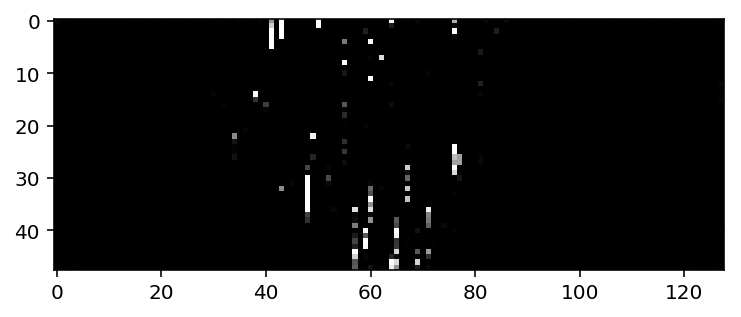

1 -0.42254093 -0.069528915
not training discriminator
75.51848


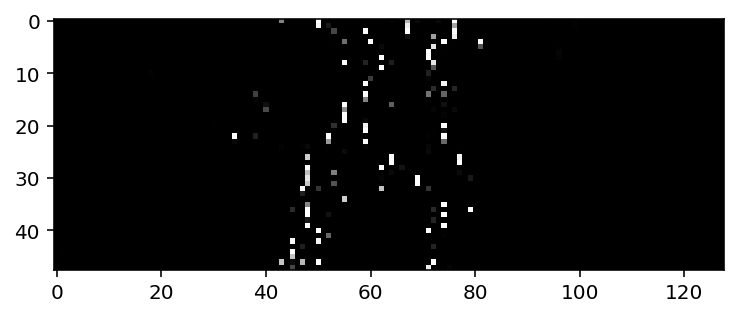

2 -0.13894159 -0.81150657
not training generator
64.94885


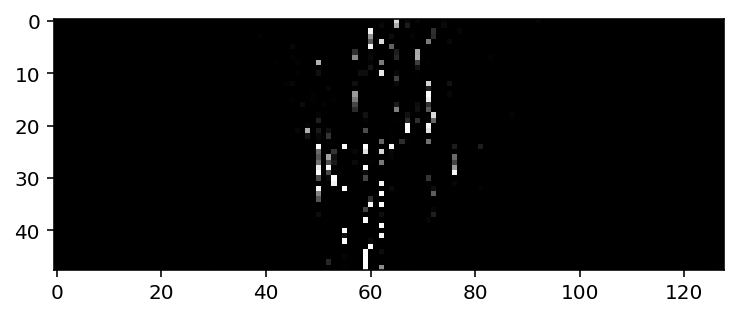

3 -0.48283765 -0.3032222
not training discriminator
69.05991


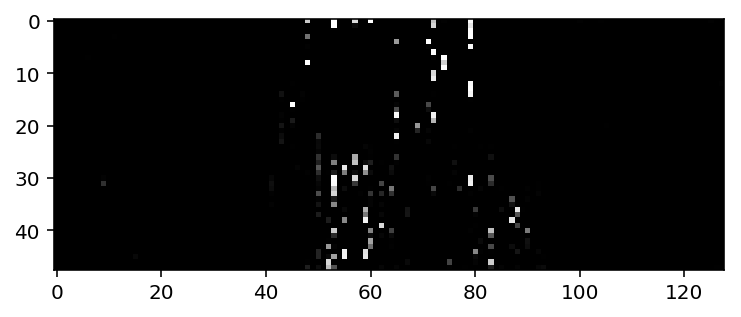

4 -0.49236766 -0.08279439
not training discriminator
85.71039


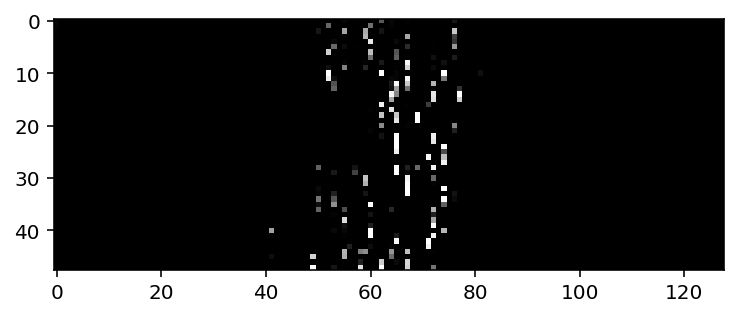

In [0]:
b = b+1
random.seed(b)
sample = []
for i in range(5):
    train_d = True
    train_g = True
    keep_prob_train = 1 # 0.5
    
    
    n = np.random.uniform(0.0, 1.0, [batch_size, n_noise]).astype(np.float32)
    batch = batch_input(midis_array ,batch_size)
    
    g_ls, d_ls = sess.run([loss_g, loss_d], feed_dict={X_in: batch, noise: n, keep_prob: keep_prob_train, is_training:True})
    
    g_ls = g_ls
    d_ls = d_ls
    
    if g_ls * 1.5 < d_ls:
      
        train_g = False
        pass
    if d_ls * 2 < g_ls:
        train_d = False
        pass
    
   # if train_d:
    for j in range(1): 
        sess.run(optimizer_d, feed_dict={noise: n, X_in: batch, keep_prob: keep_prob_train, is_training:True})
        
        
    #if train_g:
    for j in range(5): 
      
        sess.run(optimizer_g, feed_dict={noise: n, keep_prob: keep_prob_train, is_training:True})
        
        
    if not i % 1:
        print (i, d_ls, g_ls)
        if not train_g:
            print("not training generator")
        if not train_d:
            print("not training discriminator")
        gen_img = sess.run(g, feed_dict = {noise: n, keep_prob: 1.0, is_training:False})
        print(np.sum(gen_img[1,:,:,:]))
        implot = plt.imshow(gen_img[1,:,:,0], cmap="gray")
        plt.show()
        #sample = sample.append(gen_img[1,:,:,:])

In [0]:
gen_img.shape

(100, 48, 128, 1)

In [0]:
Data5 = []
for i in range(5):
  n = np.random.uniform(0.0, 1.0, [batch_size, n_noise]).astype(np.float32)
  gen_img = sess.run(g, feed_dict = {noise: n, keep_prob: 1.0, is_training:False})
  Data5.append(gen_img)


In [0]:
j = 1

92.91754


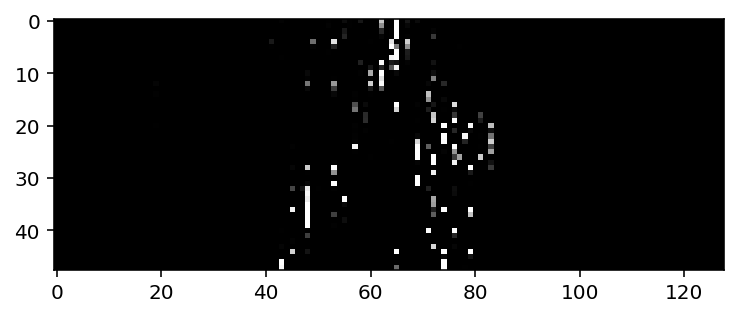

In [0]:
j +=1
print(np.sum(gen_img[4,:,:,:]))
implot = plt.imshow(gen_img[j,:,:,0], cmap="gray")
a = gen_img[j,:,:,0]
plt.show()

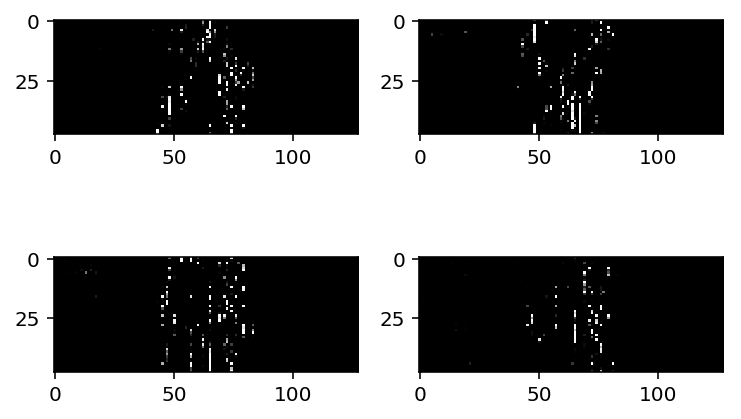

In [0]:
f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(a, cmap="gray")
axarr[0,1].imshow(a1, cmap="gray")
axarr[1,0].imshow(a2, cmap="gray")
axarr[1,1].imshow(a3, cmap="gray")



In [0]:
import matplotlib.pyplot as plt

In [0]:
j = 1

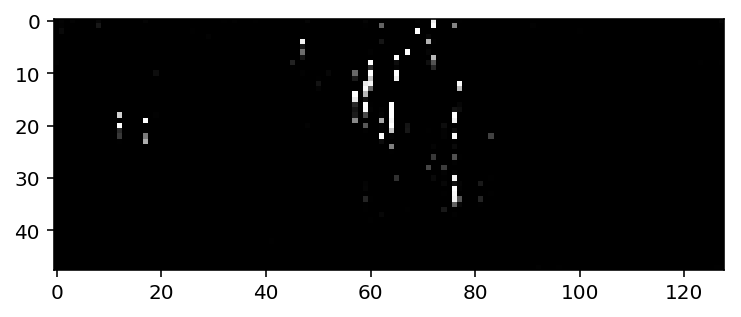

In [0]:
j = j+1
implot = plt.imshow(gen_img[j,:,:,0], cmap="gray")
plt.show()

In [0]:
result = np.round(gen_img[55,:,:,0]*2)/2

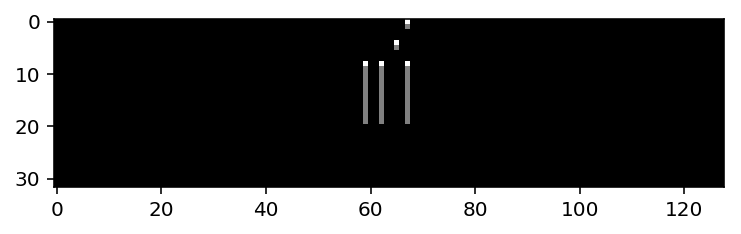

In [0]:
implot = plt.imshow(batch[5,:,:,0], cmap="gray")
plt.show()

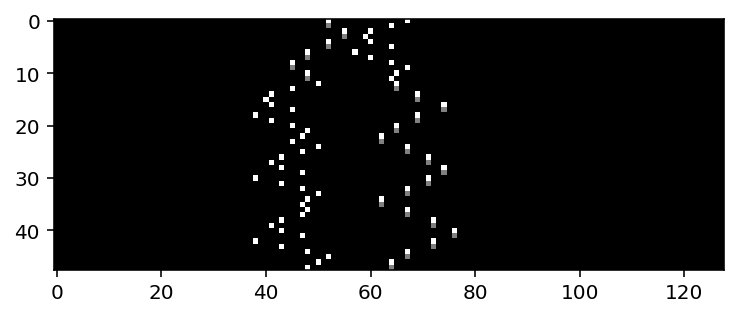

In [0]:
j+=1
implot = plt.imshow(batch[j,:,:,0], cmap="gray")
plt.show()

In [0]:
output_notes

In [0]:
filename_midi = "test21.mid"
output_notes = matrix_to_midi(result)
midi_stream = stream.Stream(output_notes)
output_filename = "/content/drive/My Drive/Music/midi_outputs/" + "test_output_" + filename_midi
midi_stream.write('midi', fp=output_filename)

How many rows for non-start note at beginning: 40
How many rows for non-start note at end: 48
32 88


'/content/drive/My Drive/Music/midi_outputs/test_output_test21.mid'

In [0]:
pip install midiutil


# Conditional DCGANs

In [0]:
def binary_cross_entropy(x, z):
    eps = 1e-12
    return (-(x * tf.log(z + eps) + (1. - x) * tf.log(1. - z + eps)))

def discriminator(img_in, reuse=None, keep_prob=None):
    with tf.variable_scope("discriminator", reuse=reuse):
        x = tf.reshape(img_in, shape=[-1, 36, 128, 1])
        x = tf.layers.conv2d(x, kernel_size=(8,5), filters=64, strides=1, padding='same', activation=tf.nn.leaky_relu)
        #x = tf.layers.dropout(x, keep_prob)
        x = tf.layers.conv2d(x, kernel_size=(5,32), filters=64, strides=1, padding='same', activation=tf.nn.leaky_relu)
        #x = tf.layers.dropout(x, keep_prob)
        #x = tf.layers.conv2d(x, kernel_size=5, filters=64, strides=1, padding='same', activation=tf.nn.leaky_relu)
        #x = tf.layers.dropout(x, keep_prob)
        x = tf.contrib.layers.flatten(x)
        x = tf.layers.dense(x, units=256, activation=tf.nn.leaky_relu)
        x = tf.layers.dense(x, units=32, activation=tf.nn.leaky_relu)
        x = tf.layers.dense(x, units=1, activation=tf.nn.sigmoid)
        return x

In [0]:
tf.reset_default_graph()
X_in = tf.placeholder(dtype=tf.float32, shape=[None, 36, 128, 1], name='X')
noise = tf.placeholder(dtype=tf.float32, shape=[None, 100])
label = tf.placeholder(dtype=tf.float32, shape=[None, 24, 128, 1])

keep_prob = tf.placeholder(dtype=tf.float32, name='keep_prob')
is_training = tf.placeholder(dtype=tf.bool, name='is_training')


def generator(z, y, keep_prob=keep_prob, is_training=is_training):
    momentum = 0.99
    with tf.variable_scope("generator", reuse=None):
        x = z
        label = tf.layers.conv2d(y, kernel_size=(8,5), filters=32, strides=1, padding='same', activation=tf.nn.leaky_relu)
        label = tf.layers.conv2d(label, kernel_size=(5,16), filters=32, strides=1, padding='same', activation=tf.nn.leaky_relu)
        label = tf.contrib.layers.flatten(label)
        label = tf.layers.dense(label, units=256, activation=tf.nn.leaky_relu)
        label = tf.layers.dense(label, units=32, activation=tf.nn.leaky_relu)
        # label is the conditional part should be 24 and x should be 8
        x = tf.concat([x, label],1)
        x = tf.layers.dense(x, units= 32, activation= tf.nn.leaky_relu)
        #x = tf.layers.dropout(x, keep_prob)
        x = tf.contrib.layers.batch_norm(x, is_training=is_training, decay=momentum)
        x = tf.reshape(x, shape=[-1, 2, 16, 1])
        x = tf.image.resize_images(x, size=[3,32])
        x = tf.layers.conv2d_transpose(x, kernel_size=(8,3), filters=64, strides=2, padding='same', activation= tf.nn.leaky_relu)
        #x = tf.layers.dropout(x, keep_prob)
        x = tf.contrib.layers.batch_norm(x, is_training=is_training, decay=momentum)
        x = tf.layers.conv2d_transpose(x, kernel_size=(4,12), filters=64, strides=2, padding='same', activation= tf.nn.leaky_relu)
        #x = tf.layers.dropout(x, keep_prob)
        x = tf.contrib.layers.batch_norm(x, is_training=is_training, decay=momentum)
        x = tf.layers.conv2d_transpose(x, kernel_size=(8,4), filters=64, strides=1, padding='same', activation= tf.nn.leaky_relu)
        #x = tf.layers.dropout(x, keep_prob)
        x = tf.contrib.layers.batch_norm(x, is_training=is_training, decay=momentum)
        x = tf.layers.conv2d_transpose(x, kernel_size=(4,12), filters=1, strides=1, padding='same', activation=tf.nn.sigmoid)
        
        return  tf.concat([y,x],1)

In [0]:
g = generator(noise, label, keep_prob, is_training)
d_real = discriminator(X_in)
d_fake = discriminator(g, reuse=True)

vars_g = [var for var in tf.trainable_variables() if var.name.startswith("generator")]
vars_d = [var for var in tf.trainable_variables() if var.name.startswith("discriminator")]


d_reg = tf.contrib.layers.apply_regularization(tf.contrib.layers.l2_regularizer(0.01), vars_d)
g_reg = tf.contrib.layers.apply_regularization(tf.contrib.layers.l2_regularizer(0.01), vars_g)

loss_d_real = binary_cross_entropy(tf.ones_like(d_real), d_real)
loss_d_fake = binary_cross_entropy(tf.zeros_like(d_fake), d_fake)

loss_g = tf.reduce_mean(binary_cross_entropy(tf.ones_like(d_fake), d_fake))
loss_d = tf.reduce_mean(0.5 * (loss_d_real + loss_d_fake))

"""

loss_d = tf.contrib.gan.losses.wargs.wasserstein_discriminator_loss(d_real, d_fake)
loss_g = tf.contrib.gan.losses.wargs.wasserstein_generator_loss(d_fake)

d_loss_real = - tf.reduce_mean(d_real)
d_loss_fake = tf.reduce_mean(d_fake)

loss_d = d_loss_real + d_loss_fake
loss_g = - d_loss_fake
"""




update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    optimizer_d = tf.train.RMSPropOptimizer(learning_rate=0.00015).minimize(loss_d + d_reg, var_list=vars_d)
    optimizer_g = tf.train.RMSPropOptimizer(learning_rate=0.00015).minimize(loss_g + g_reg, var_list=vars_g)
    
# weight clipping
#vars_d = [p.assign(tf.clip_by_value(p, -0.05, 0.05)) for p in vars_d]    

saver = tf.train.Saver()    
sess = tf.Session()
sess.run(tf.global_variables_initializer())


In [0]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

In [0]:
n_noise =100
batch_size = 20
midis_array = tf.reshape(midis_array, shape=[-1, 36, 128, 1])
midis_array = tf.Session().run(midis_array)

In [0]:
def batch_input(x,n):
  # x = [None, 48, 128, 1]
  z = x
  np.random.shuffle(z)
  return z[0:n,:,:,:]

def batch_input2(x,n):
  # x = [None, 24, 128, 1]
  z = x
  np.random.shuffle(z)
  return z[0:n,0:24,:,:]

def batch_input3(x,n):
  # x = [1, 24, 128, 1]
  z = x
  np.random.shuffle(z)
  return z[0:100,0:24,:,:]


import random
import matplotlib.pyplot as plt

batch = batch_input(midis_array, batch_size)
batch.shape

batch_size = 100
b = 1


In [0]:
saver.restore(sess, '/content/drive/My Drive/Music/Weight/01/train_model_CGANs0818.ckpt')

In [0]:
b = b+1
random.seed(b)
sample = []
for i in range(60000):
    train_d = True
    train_g = True
    keep_prob_train = 0.6 # 0.5
    
    
    n = np.random.uniform(0.0, 1.0, [batch_size, n_noise]).astype(np.float32)
    batch = batch_input(midis_array ,batch_size)
    batch2 = batch_input2(midis_array ,batch_size)
    test = batch_input3(midis_array ,batch_size)
    
    g_ls, d_ls = sess.run([loss_g, loss_d], feed_dict={label:batch2, X_in: batch, noise: n, keep_prob: keep_prob_train, is_training:True})
    
    g_ls = g_ls
    d_ls = d_ls
    
    if g_ls * 1.5 < d_ls:
        train_g = False
        pass
      
    if d_ls * 3 < g_ls:
        train_d = False
        pass
  
    if train_d:
        sess.run(optimizer_d, feed_dict={noise: n, label:batch2, X_in: batch, keep_prob: keep_prob_train, is_training:True})
        
        
    if train_g:
        sess.run(optimizer_g, feed_dict={noise: n, label: batch2, keep_prob: keep_prob_train, is_training:True})
        
        
    if not i % 30:
        print (i, d_ls, g_ls)
        if not train_g:
            print("not training generator")
        if not train_d:
            print("not training discriminator")
        gen_img = sess.run(g, feed_dict = {noise: n, label: test, keep_prob: 1.0, is_training:False})
        print(np.sum(gen_img[1,:,:,:]))
        implot = plt.imshow(gen_img[1,:,:,0], cmap="gray")
        plt.show()
        image = test[2:3,:,:,:]
        music = image
        for i in range(4):
          gen_img = sess.run(g, feed_dict = {noise: np.random.uniform(0.0, 1.0, [1, n_noise]).astype(np.float32), 
                                             label: image, keep_prob: 1.0, is_training:False})
          gen_img=np.asarray(gen_img)*2
          music = np.column_stack((music, gen_img[:,24:36,:,:]))

          image = gen_img[:,12:36,:,:]
        implot = plt.imshow(music.reshape(72,128), cmap="gray")
        plt.show()
    if not i % 4000:
      #saver.save(sess, '/content/drive/My Drive/Music/Weight/01/train_model_CGANs0740.ckpt')
    #sample = sample.append(gen_img[1,:,:,:])
        

In [0]:
gen_img = sess.run(g, feed_dict = {noise: n[0:1,:], label: test[0:1,:,:,:], keep_prob: 1.0, is_training:False})

In [0]:
saver.save(sess, '/content/drive/My Drive/Music/Weight/01/train_model_CGANs0818.ckpt')

'/content/drive/My Drive/Music/Weight/01/train_model_CGANs0818.ckpt'

In [0]:
image = test[j:j+1,:,:,:]
music = image
for i in range(5):
  gen_img = sess.run(g, feed_dict = {noise: np.random.uniform(0.0, 1.0, [1, n_noise]).astype(np.float32), 
                                     label: image, keep_prob: 1.0, is_training:False})
  gen_img=np.asarray(gen_img)
  music = np.column_stack((music, gen_img[:,24:32,:,:]))

  image = gen_img[:,8:32,:,:]
implot = plt.imshow(music.reshape(64,128), cmap="gray")
plt.show()

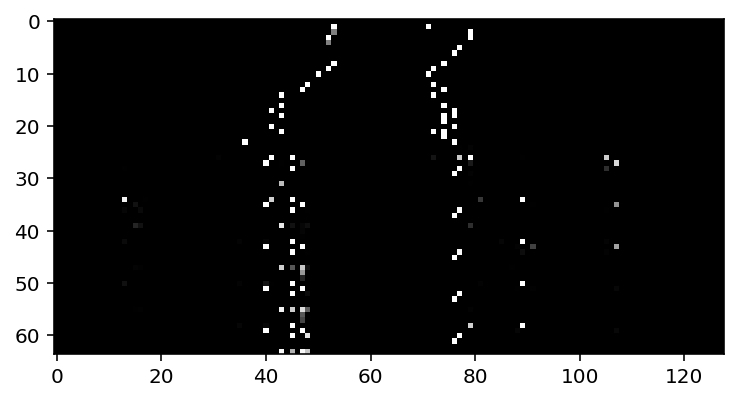

In [0]:
implot = plt.imshow(music.reshape(64,128), cmap="gray")
plt.show()

In [0]:
from midiutil.MidiFile import MIDIFile

matrix = music[0,:,:,0]
# create your MIDI object
mf = MIDIFile(1)     # only 1 track
track = 0   # the only track

time = 0    # start at the beginning
mf.addTrackName(track, time, "Sample Track")
mf.addTempo(track, time, 120)

# add some notes
channel = 0
volume = 100
'''
pitch = 60           # C4 (middle C)
time = 0             # start on beat 0
duration = 1         # 1 beat long
mf.addNote(track, channel, pitch, time, duration, volume)

pitch = 64           # E4
time = 2             # start on beat 2
duration = 1         # 1 beat long
mf.addNote(track, channel, pitch, time, duration, volume)

pitch = 67           # G4
time = 4             # start on beat 4
duration = 1         # 1 beat long
mf.addNote(track, channel, pitch, time, duration, volume)
'''
for pitch in range(0,128):
  time = 0
  while time < 64:
    duration = 1
    if matrix[time, pitch]>=0.75:
      if time <63:
        while (matrix[time+duration, pitch]>=0.25)*(matrix[time+duration, pitch]<0.75)*(time+duration < 63):
            duration  = duration+1            
      mf.addNote(track, channel, pitch, time, duration, volume)
    if (matrix[time, pitch]>= 0.5)*(matrix[time-1, pitch]== 0):  
      if time <63:
        while (matrix[time+duration, pitch]>=0.25)*(matrix[time+duration, pitch]<0.75)*(time+duration < 63):
            duration  = duration+1            
      mf.addNote(track, channel, pitch, time, duration, volume)      
    
    time +=1
    


# write it to disk
with open("output4.mid", 'wb') as outf:
    mf.writeFile(outf)  

In [0]:
for file in os.listdir(os.getcwd()):
    if file.endswith("output4.mid"):
      files.download(file)

#Conditional DCGANs (some other experiment)

In [0]:
keep_prob=0.99

In [0]:
def binary_cross_entropy(x, z):
    eps = 1e-12
    return (-(x * tf.log(z + eps) + (1. - x) * tf.log(1. - z + eps)))

def discriminator(img_in, reuse=None, keep_prob=None):
    with tf.variable_scope("discriminator", reuse=reuse):
        x = tf.reshape(img_in, shape=[-1, 48, 128, 1])
        x = tf.layers.conv2d(x, kernel_size=(8,5), filters=64, strides=1, padding='same', activation=tf.nn.leaky_relu)
        #x = tf.layers.dropout(x, keep_prob)
        x = tf.layers.conv2d(x, kernel_size=(5,32), filters=64, strides=1, padding='same', activation=tf.nn.leaky_relu)
        #x = tf.layers.dropout(x, keep_prob)
        #x = tf.layers.conv2d(x, kernel_size=5, filters=64, strides=1, padding='same', activation=tf.nn.leaky_relu)
        #x = tf.layers.dropout(x, keep_prob)
        x = tf.contrib.layers.flatten(x)
        x = tf.layers.dense(x, units=256, activation=tf.nn.leaky_relu)
        x = tf.layers.dense(x, units=32, activation=tf.nn.leaky_relu)
        x = tf.layers.dense(x, units=1, activation=tf.nn.sigmoid)
        return x

In [0]:
tf.reset_default_graph()
X_in = tf.placeholder(dtype=tf.float32, shape=[None, 48, 128, 1], name='X')
noise = tf.placeholder(dtype=tf.float32, shape=[None, 100])
label = tf.placeholder(dtype=tf.float32, shape=[None, 24, 128, 1])

keep_prob = tf.placeholder(dtype=tf.float32, name='keep_prob')
is_training = tf.placeholder(dtype=tf.bool, name='is_training')


def generator(z, y, keep_prob=keep_prob, is_training=is_training):
    momentum = 0.99
    with tf.variable_scope("generator", reuse=None):
        x = z
        label = tf.layers.conv2d(y, kernel_size=(8,5), filters=32, strides=1, padding='same', activation=tf.nn.leaky_relu)
        label = tf.layers.conv2d(label, kernel_size=(5,16), filters=32, strides=1, padding='same', activation=tf.nn.leaky_relu)
        label = tf.contrib.layers.flatten(label)
        label = tf.layers.dense(label, units=256, activation=tf.nn.leaky_relu)
        label = tf.layers.dense(label, units=32, activation=tf.nn.leaky_relu)
        # label is the conditional part should be 24 and x should be 8
        x = tf.concat([x, label],1)
        x = tf.layers.dense(x, units= 32, activation= tf.nn.leaky_relu)
        #x = tf.layers.dropout(x, keep_prob)
        x = tf.contrib.layers.batch_norm(x, is_training=is_training, decay=momentum)
        x = tf.reshape(x, shape=[-1, 2, 16, 1])
        x = tf.image.resize_images(x, size=[6,32])
        x = tf.layers.conv2d_transpose(x, kernel_size=(8,3), filters=64, strides=2, padding='same', activation= tf.nn.leaky_relu)
        #x = tf.layers.dropout(x, keep_prob)
        x = tf.contrib.layers.batch_norm(x, is_training=is_training, decay=momentum)
        x = tf.layers.conv2d_transpose(x, kernel_size=(4,12), filters=64, strides=2, padding='same', activation= tf.nn.leaky_relu)
        #x = tf.layers.dropout(x, keep_prob)
        x = tf.contrib.layers.batch_norm(x, is_training=is_training, decay=momentum)
        x = tf.layers.conv2d_transpose(x, kernel_size=(8,4), filters=64, strides=1, padding='same', activation= tf.nn.leaky_relu)
        #x = tf.layers.dropout(x, keep_prob)
        x = tf.contrib.layers.batch_norm(x, is_training=is_training, decay=momentum)
        x = tf.layers.conv2d_transpose(x, kernel_size=(4,12), filters=1, strides=1, padding='same', activation=tf.nn.sigmoid)
        
        return  tf.concat([y,x],1)

In [0]:
g = generator(noise, label, keep_prob, is_training)
d_real = discriminator(X_in)
d_fake = discriminator(g, reuse=True)

vars_g = [var for var in tf.trainable_variables() if var.name.startswith("generator")]
vars_d = [var for var in tf.trainable_variables() if var.name.startswith("discriminator")]


d_reg = tf.contrib.layers.apply_regularization(tf.contrib.layers.l2_regularizer(0.01), vars_d)
g_reg = tf.contrib.layers.apply_regularization(tf.contrib.layers.l2_regularizer(0.01), vars_g)

"""

loss_d_real = binary_cross_entropy(tf.ones_like(d_real), d_real)
loss_d_fake = binary_cross_entropy(tf.zeros_like(d_fake), d_fake)

loss_g = tf.reduce_mean(binary_cross_entropy(tf.ones_like(d_fake), d_fake))
loss_d = tf.reduce_mean(0.5 * (loss_d_real + loss_d_fake))

d_loss_real = - tf.reduce_mean(d_real)
d_loss_fake = tf.reduce_mean(d_fake)

loss_d = d_loss_real + d_loss_fake
loss_g = - d_loss_fake
"""


loss_d = tf.contrib.gan.losses.wargs.wasserstein_discriminator_loss(d_real, d_fake)
loss_g = tf.contrib.gan.losses.wargs.wasserstein_generator_loss(d_fake)



update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    optimizer_d = tf.train.RMSPropOptimizer(learning_rate=0.00015).minimize(loss_d + d_reg, var_list=vars_d)
    optimizer_g = tf.train.RMSPropOptimizer(learning_rate=0.00015).minimize(loss_g + g_reg, var_list=vars_g)
    
# weight clipping
vars_d = [p.assign(tf.clip_by_value(p, -0.05, 0.05)) for p in vars_d]    

saver = tf.train.Saver()   
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [0]:
n_noise =100
batch_size = 20
midis_array = tf.reshape(midis_array, shape=[-1, 48, 128, 1])
midis_array = tf.Session().run(midis_array)

In [0]:
def batch_input(x,n):
  # x = [None, 32, 128, 1]
  z = x
  np.random.shuffle(z)
  return z[0:n,:,:,:]

def batch_input2(x,n):
  # x = [None, 24, 128, 1]
  z = x
  np.random.shuffle(z)
  return z[0:n,0:24,:,:]

def batch_input3(x,n):
  # x = [1, 24, 128, 1]
  z = x
  np.random.shuffle(z)
  return z[0:n,0:24,:,:]


import random
import matplotlib.pyplot as plt

batch = batch_input(midis_array, batch_size)
batch.shape

batch_size = 100
b = 1


In [0]:

saver.restore(sess, '/content/drive/My Drive/Music/Weight/03/train_model_CGANs_was_RMS_0.00015.ckpt')

In [0]:
midis_array.shape

(5417, 48, 128, 1)

In [0]:
batch_input3(midis_array ,1000).shape

(1000, 24, 128, 1)

In [0]:
gen_img.shape

(1000, 48, 128, 1)

In [0]:
gen_img = sess.run(g, feed_dict = {noise: np.random.uniform(0.0, 1.0, [1000, n_noise]).astype(np.float32), 
                                     label: batch_input3(midis_array ,1000), keep_prob: 1.0, is_training:False})
gen_img=np.asarray(gen_img)

In [0]:
gen_img.shape

(1000, 48, 128, 1)

In [0]:
j = 1

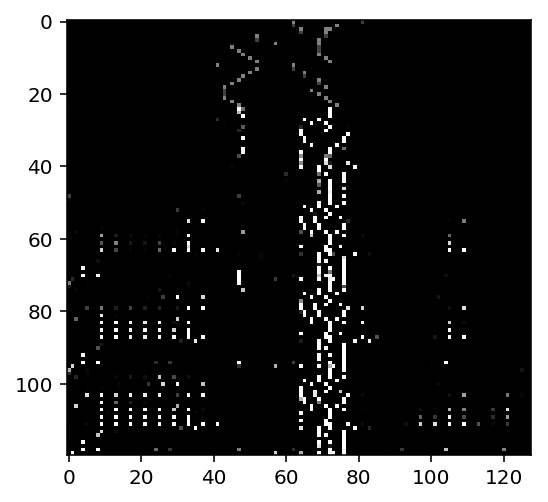

In [0]:
j+=1
image = test[j:j+1,:,:,:]
music = image
for i in range(4):
  gen_img = sess.run(g, feed_dict = {noise: np.random.uniform(0.0, 1.0, [1, n_noise]).astype(np.float32), 
                                     label: image, keep_prob: 1.0, is_training:False})
  gen_img=np.asarray(gen_img)*2
  music = np.column_stack((music, gen_img[:,24:48,:,:]))

  image = gen_img[:,24:48,:,:]
implot = plt.imshow(music.reshape(120,128), cmap="gray")
plt.show()

In [0]:
11264/128

88.0

In [0]:
j =1

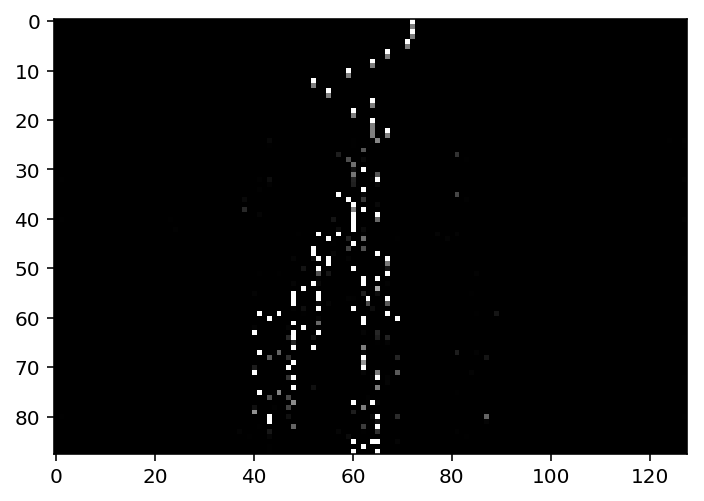

In [0]:
test = batch_input3(midis_array ,100)
j+=1
image = test[j:j+1,:,:,:]
music = image
for i in range(8):
  gen_img = sess.run(g, feed_dict = {noise: np.random.uniform(0.0, 1.0, [1, n_noise]).astype(np.float32), 
                                     label: image, keep_prob: 1.0, is_training:False})
  gen_img=np.asarray(gen_img)
  
  gen_img= gen_img[0,:,:,0]
  for pitch in range(0,128):
    time = 0
    while time < 48:
      duration = 1
      if gen_img[time, pitch]>=0.7:
        gen_img[time, pitch] = 1
        if time <47:
          while (gen_img[time+duration, pitch]>=0.65)*(gen_img[time+duration, pitch]<0.7)*(time+duration < 47):
              gen_img[time+duration, pitch] = 0.5
              duration  = duration+1                    

      time +=1
  gen_img = gen_img.reshape(1,48,128,1)
  music = np.column_stack((music, gen_img[:,24:32,:,:]))

  image = gen_img[:,8:32,:,:]
implot = plt.imshow(music.reshape(88,128), cmap="gray")

plt.show()

0 -0.68973595 -0.0037582903
not training discriminator
93.53967


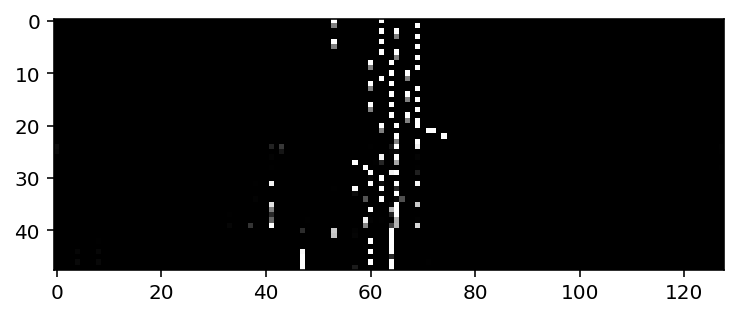

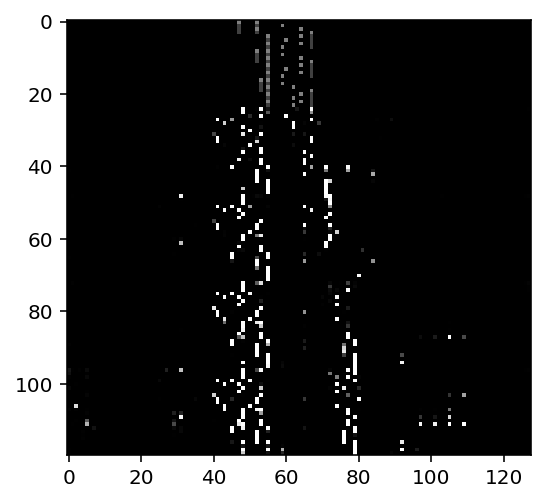

In [0]:

b = b+1
random.seed(b)
sample = []
for i in range(1):
    train_d = True
    train_g = True
    keep_prob_train = 0.6 # 0.5
    
    
    n = np.random.uniform(0.0, 1.0, [batch_size, n_noise]).astype(np.float32)
    batch = batch_input(midis_array ,batch_size)
    batch2 = batch_input2(midis_array ,batch_size)
    test = batch_input3(midis_array ,batch_size)
    
    g_ls, d_ls = sess.run([loss_g, loss_d], feed_dict={label:batch2, X_in: batch, noise: n, keep_prob: keep_prob_train, is_training:True})
    
    g_ls = g_ls
    d_ls = d_ls

    if g_ls * 1.5 < d_ls:
        train_g = False
        pass
      
    if d_ls * 3 < g_ls:
        train_d = False
        pass

    #if train_d:
    for j in range(1):
        sess.run(optimizer_d, feed_dict={noise: n, label:batch2, X_in: batch, keep_prob: keep_prob_train, is_training:True})
        
        
    #if train_g:
    for j in range(5):
        sess.run(optimizer_g, feed_dict={noise: n, label: batch2, keep_prob: keep_prob_train, is_training:True})
             
        
    if not i % 1:
        print (i, d_ls, g_ls)
        if not train_g:
            print("not training generator")
        if not train_d:
            print("not training discriminator")
        gen_img = sess.run(g, feed_dict = {noise: n, label: test, keep_prob: 1.0, is_training:False})
        print(np.sum(gen_img[1,:,:,:]))
        implot = plt.imshow(gen_img[1,:,:,0], cmap="gray")
        plt.show()
        image = test[2:3,:,:,:]
        music = image
        for i in range(4):
          gen_img = sess.run(g, feed_dict = {noise: np.random.uniform(0.0, 1.0, [1, n_noise]).astype(np.float32), 
                                             label: image, keep_prob: 1.0, is_training:False})
          gen_img=np.asarray(gen_img)*2
          music = np.column_stack((music, gen_img[:,24:48,:,:]))

          image = gen_img[:,24:48,:,:]
        implot = plt.imshow(music.reshape(120,128), cmap="gray")
        plt.show()
     
    if not i % 5000:
      saver.save(sess, '/content/drive/My Drive/Music/Weight/03/train_model_CGANs_new01.ckpt')

        #sample = sample.append(gen_img[1,:,:,:])
#saver.save(sess, '/content/drive/My Drive/Music/Weight/03/train_model_CGANs090.ckpt')

In [0]:
gen_img = sess.run(g, feed_dict = {noise: n[0:1,:], label: test[0:1,:,:,:], keep_prob: 1.0, is_training:False})

In [0]:
saver.save(sess, '/content/drive/My Drive/Music/Weight/03/train_model_CGANs_was_RMS_0.00015.ckpt')

'/content/drive/My Drive/Music/Weight/03/train_model_CGANs_was_RMS_0.00015.ckpt'

In [0]:
j = 1

In [0]:
for pitch in range(0,128):
  time = 0
  while time < 64:
    duration = 1
    if matrix[time, pitch]>=0.7:
      matrix[time, pitch] = 1
      if time <63:
        while (matrix[time+duration, pitch]>=0.25)*(matrix[time+duration, pitch]<0.7)*(time+duration < 63):
            matrix[time, pitch] = 0.5
            duration  = duration+1            
    if (matrix[time, pitch]>= 0.5)*(matrix[time-1, pitch]<0.25):  
      if time <63:
        while (matrix[time+duration, pitch]>=0.25)*(matrix[time+duration, pitch]<0.7)*(time+duration < 63):
            duration  = duration+1               
    
    time +=1

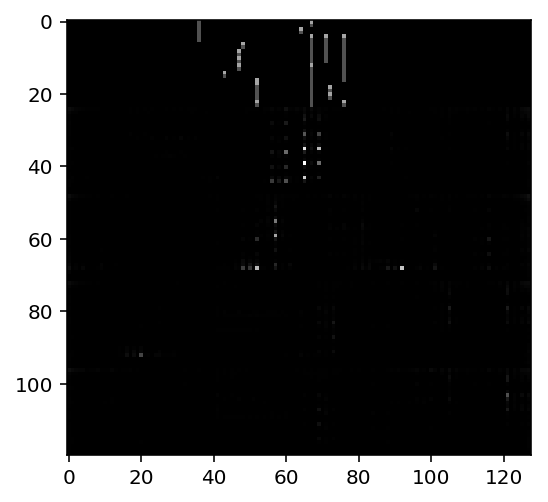

In [0]:
j+=1
image = test[j:j+1,:,:,:]
music = image
for i in range(4):
  gen_img = sess.run(g, feed_dict = {noise: np.random.uniform(0.0, 1.0, [1, n_noise]).astype(np.float32), 
                                     label: image, keep_prob: 1.0, is_training:False})
  gen_img=np.asarray(gen_img)*2
  music = np.column_stack((music, gen_img[:,24:48,:,:]))

  image = gen_img[:,24:48,:,:]
implot = plt.imshow(music.reshape(120,128), cmap="gray")

In [0]:
np.asarray(music).shape

(1, 84, 128, 1)

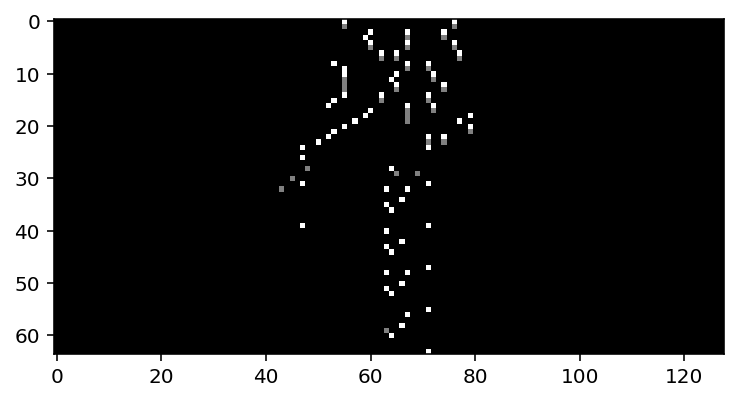

In [0]:
implot = plt.imshow(music.reshape(64,128), cmap="gray")
plt.show()

# Generate and Download MIDI files


In [0]:
pip install midiutil

     |████████████████████████████████| 1.0MB 3.4MB/s 
  Created wheel for midiutil: filename=MIDIUtil-1.2.1-cp36-none-any.whl size=54569 sha256=9f20a896aec2be70eb5dda0170a2a74ea045b3f2d87b2234fc0697c03ae804e5
  Stored in directory: /root/.cache/pip/wheels/70/f1/24/97bde012f64820632e1e5e2935df19dfbcf9e058b0734b57cd
Successfully built midiutil


In [0]:
music.shape

(1, 84, 128, 1)

In [0]:
from google.colab import files
from midiutil.MidiFile import MIDIFile

matrix = music[0,:,:,0]
# create your MIDI object
mf = MIDIFile(1)     # only 1 track
track = 0   # the only track

time = 0    # start at the beginning
mf.addTrackName(track, time, "Sample Track")
mf.addTempo(track, time, 120)

# add some notes
channel = 0
volume = 100
'''
pitch = 60           # C4 (middle C)
time = 0             # start on beat 0
duration = 1         # 1 beat long
mf.addNote(track, channel, pitch, time, duration, volume)

pitch = 64           # E4
time = 2             # start on beat 2
duration = 1         # 1 beat long
mf.addNote(track, channel, pitch, time, duration, volume)

pitch = 67           # G4
time = 4             # start on beat 4
duration = 1         # 1 beat long
mf.addNote(track, channel, pitch, time, duration, volume)
'''
for pitch in range(0,128):
  time = 0
  while time < 64:
    duration = 1
    if matrix[time, pitch]>=0.7:
      if time <63:
        while (matrix[time+duration, pitch]>=0.25)*(matrix[time+duration, pitch]<0.7)*(time+duration < 63):
            duration  = duration+1            
      mf.addNote(track, channel, pitch, time, duration, volume)
    if (matrix[time, pitch]>= 0.5)*(matrix[time-1, pitch]<0.25):  
      if time <63:
        while (matrix[time+duration, pitch]>=0.25)*(matrix[time+duration, pitch]<0.7)*(time+duration < 63):
            duration  = duration+1            
      mf.addNote(track, channel, pitch, time, duration, volume)      
    
    time +=1
    


# write it to disk
with open("output4.mid", 'wb') as outf:
    mf.writeFile(outf)  
    
for file in os.listdir(os.getcwd()):
    if file.endswith("output4.mid"):
      files.download(file)    

In [0]:

for file in os.listdir(os.getcwd()):
    if file.endswith("output4.mid"):
      files.download(file)

#Test-Classifier

In [0]:
a = 48
data=[]
b = 1

for i, file in enumerate(glob.glob("/content/drive/My Drive/Music/*.mid")):
      print(i)
      print(file)
      data_temp = midi_to_matrix(file)
      b += 1
      for j in range(int(np.floor(data_temp[0,:].shape[0]-a))):
          if not j%6:          
            #if np.sum(data_temp[:,j:(j+a)]==0.5)-np.sum(data_temp[:,j:(j+a)]==1) <=30:
             # if np.sum(data_temp[:,j:(j+a)]==1)>=20:
                 data.append(data_temp[:,j:(j+a)])

In [0]:
midis_arraytest = np.asarray(data)
    
midis_arraytest = np.transpose(midis_arraytest, (0, 2, 1)) 
midis_arraytest = np.asarray(midis_arraytest)
midis_arraytest =midis_arraytest.reshape(-1,48,128,1)

In [0]:
midis_array =midis_array.reshape(-1,48,128,1)

In [0]:
def batch_input(x,n):
  # x = [None, 48, 128, 1]
  z = x
  np.random.shuffle(z)
  return z[0:n,:,:,:]

def batch_input2(x,n):
  # x = [None, 24, 128, 1]
  z = x
  np.random.shuffle(z)
  return z[0:n,0:24,:,:]

def batch_input3(x,n):
  # x = [1, 24, 128, 1]
  z = x
  np.random.shuffle(z)
  return z[0:100,0:24,:,:]

b = 1

In [0]:
midis_arraytest.shape  

In [0]:
(label-y_).shape

In [0]:
tf.reset_default_graph()
x_in = tf.placeholder(dtype=tf.float32, shape=[None, 48, 128, 1], name='X')
label = tf.placeholder(dtype=tf.float32, shape=[None, 1])

keep_prob = tf.placeholder(dtype=tf.float32, name='keep_prob')
is_training = tf.placeholder(dtype=tf.bool, name='is_training')

x = tf.layers.conv2d(x_in, kernel_size=(8,5), filters=64, strides=1, padding='same', activation=tf.nn.leaky_relu)
#x = tf.layers.dropout(x, keep_prob)
x = tf.layers.conv2d(x, kernel_size=(5,32), filters=64, strides=1, padding='same', activation=tf.nn.leaky_relu)
x = tf.contrib.layers.flatten(x)
x = tf.layers.dense(x, units=256, activation=tf.nn.leaky_relu)
x = tf.layers.dense(x, units=32, activation=tf.nn.leaky_relu)
y_ = tf.layers.dense(x, units=1, activation=tf.nn.sigmoid)


vars1 = [var for var in tf.trainable_variables()]

reg = tf.contrib.layers.apply_regularization(tf.contrib.layers.l2_regularizer(0.01), vars1)


loss =tf.reduce_mean(binary_cross_entropy(label,y_))
acc = tf.reduce_mean(tf.abs(tf.round(label-y_)))
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
optimizer = tf.train.RMSPropOptimizer(learning_rate=0.001).minimize(loss+reg, var_list=vars1)
    #optimizer_g = tf.train.RMSPropOptimizer(learning_rate=0.00015).minimize(loss_g + g_reg, var_list=vars_g)
saver = tf.train.Saver()   
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [0]:

saver.restore(sess, '/content/drive/My Drive/Music/Weight/test/BachvsPop425.ckpt')

In [0]:
saver.restore(sess, '/content/drive/My Drive/Music/Weight/test/BachvsChopin111.ckpt')

In [0]:
gen_img.shape

(100, 48, 128, 1)

In [0]:
#gen_img = sess.run(g, feed_dict = {noise: np.random.uniform(0.0, 1.0, [1, n_noise]).astype(np.float32),  label: image, keep_prob: 1.0, is_training:False})
a = np.ones(100).reshape(100,1)
acc = sess.run([acc], feed_dict={label:a, x_in: gen_img[0:100,:,:,:], is_training:False})


In [0]:
train = []
test = []
acc1 = []
acc2 = []
a = np.ones(100).reshape(100,1)
b = np.zeros(100).reshape(100,1)


batch1 = batch_input(midis_array[0:2000,:,:,:] ,2000)
batch2 = batch_input(midis_arraytest[0:2000,:,:,:],2000)


batch3 =midis_array[2000:2500,:,:,:] 
batch4 = midis_arraytest[2000:2500,:,:,:]
c= np.ones(500).reshape(500,1)
d= np.zeros(500).reshape(500,1)

In [0]:
np.concatenate((a, b), axis = 0).shape

(200, 1)

In [0]:

for i in range(5):
    
    for j in range(20):
      j = j*100
      train_ls, acctrain= sess.run([loss, acc], feed_dict={label: np.concatenate((a, b), axis = 0), x_in: np.concatenate((batch1[j:j+100,:,:,:], batch2[j:j+100,:,:,:]), axis = 0)})
      sess.run(optimizer, feed_dict={label: np.concatenate((a, b), axis = 0), x_in: np.concatenate((batch1[j:j+100,:,:,:], batch2[j:j+100,:,:,:]), axis = 0)})

    
    test_ls, acctest = sess.run([loss, acc], feed_dict = {label: np.concatenate((c, d), axis = 0), x_in: np.concatenate((batch3, batch4), axis = 0), is_training:False})
    
    train.append(train_ls)
    test.append(test_ls)
    acc1.append(acctrain)
    acc2.append(acctest)
    
    print(train_ls, acctrain )  
    print(test_ls, acctest )   
        


0.079399526 0.01
0.28376234 0.124
0.11330719 0.055
0.8436552 0.337
0.12879115 0.06
0.28566012 0.107
0.06286223 0.015
0.33599755 0.162
0.07625281 0.025
0.22630869 0.078


In [0]:
batch3 =midis_array[3500:4000,:,:,:] 
batch4 = midis_arraytest[3500:4000,:,:,:]
c= np.ones(500).reshape(500,1)
d= np.zeros(500).reshape(500,1)

In [0]:
test_ls, acctest = sess.run([loss, acc], feed_dict = {label: np.concatenate((c, d), axis = 0), x_in: np.concatenate((batch3, batch4), axis = 0), is_training:False})

In [0]:
acctest

0.129

In [0]:
batch1 = batch_input(midis_array ,50)
batch2 = batch_input(midis_arraytest ,50)
    
ls= sess.run([loss], feed_dict = {label:np.zeros(50).reshape(50,1) , x_in: batch_input(midis_arraytest ,50), is_training:False})
print(ls)

[0.0058128033]


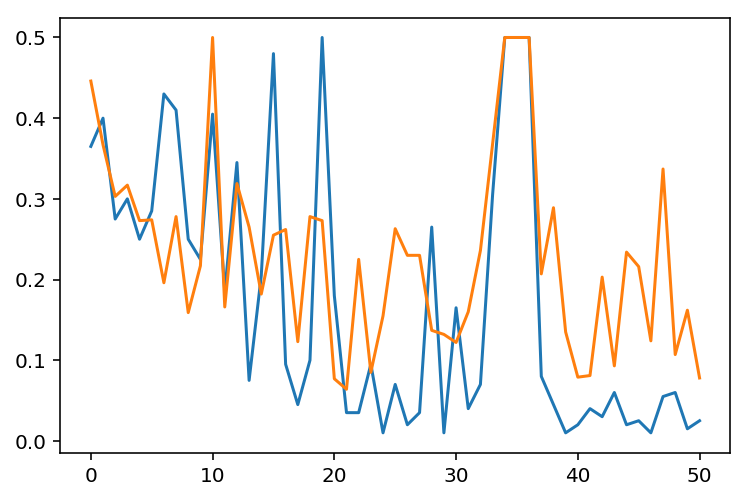

In [0]:


implot = plt.plot(np.asarray(acc1))
implot = plt.plot(np.asarray(acc2))
plt.show()

In [0]:
saver.save(sess, '/content/drive/My Drive/Music/Weight/test/BachvsPop425.ckpt')

'/content/drive/My Drive/Music/Weight/test/BachvsPop425.ckpt'

#t-SNE (2D and 3D trials)

In [0]:
"/content/drive/My Drive/Music/*.mid"
"/content/drive/My Drive/Music/ChopinMusic/*.mid"
"/content/drive/My Drive/MusicBachViolin/*.mid"
"/content/drive/My Drive/musicBach/new/*.mid"


In [0]:
a = 48
data=[]
b = 1

for i, file in enumerate(glob.glob("/content/drive/My Drive/musicBach/new/*.mid")):
      print(i,file)
      data_temp = midi_to_matrix(file)
      b += 1
      for j in range(int(np.floor(data_temp[0,:].shape[0]-a))):
          if not j%8:          
            #if np.sum(data_temp[:,j:(j+a)]==0.5)-np.sum(data_temp[:,j:(j+a)]==1) <=30:
             # if np.sum(data_temp[:,j:(j+a)]==1)>=20:
                 data.append(data_temp[:,j:(j+a)])

0 /content/drive/My Drive/musicBach/new/pre_c2.mid
1 /content/drive/My Drive/musicBach/new/min_gm.mid
2 /content/drive/My Drive/musicBach/new/pol_gm.mid
3 /content/drive/My Drive/musicBach/new/pol_gm2.mid
4 /content/drive/My Drive/musicBach/new/mus_g.mid
5 /content/drive/My Drive/musicBach/new/min_gm2.mid
6 /content/drive/My Drive/musicBach/new/min_e.mid
7 /content/drive/My Drive/musicBach/new/min_g.mid
8 /content/drive/My Drive/musicBach/new/min_g1.mid
9 /content/drive/My Drive/musicBach/new/pre_c.mid
10 /content/drive/My Drive/musicBach/new/min_dm.mid
11 /content/drive/My Drive/musicBach/new/min_bb.mid
12 /content/drive/My Drive/musicBach/new/mch_d.mid
13 /content/drive/My Drive/musicBach/new/bjses1gy.mid
14 /content/drive/My Drive/musicBach/new/bach-prelude-in-cm-piano.mid
15 /content/drive/My Drive/musicBach/new/bach1.mid
16 /content/drive/My Drive/musicBach/new/invention2part-no13.mid
17 /content/drive/My Drive/musicBach/new/bach-bourree-in-e-minor-piano.mid
18 /content/drive/My D

In [0]:
midis_array = np.asarray(data)
    
midis_array = np.transpose(midis_array, (0, 2, 1)) 
midis_array = np.asarray(midis_array)
midis_array.shape 

(5417, 48, 128)

In [0]:
def batch_input(x,n):
  # x = [None, 48, 128, 1]
  z = x
  np.random.shuffle(z)
  return z[0:n,:,:,:]

In [0]:
#piano
Data1 = midis_array.reshape(-1,48,128,1)
Data1.shape

(5417, 48, 128, 1)

In [0]:
#Violin
Data2 = midis_array.reshape(-1,48,128,1)
Data2.shape

(3058, 48, 128, 1)

In [0]:
#Chopin
Data3 = midis_array.reshape(-1,48,128,1)
Data3.shape

(4392, 48, 128, 1)

In [0]:
#some
Data4 = midis_array.reshape(-1,48,128,1)
Data4.shape

(4341, 48, 128, 1)

In [0]:
Data5 =np.asarray(Data5).reshape(500,48,128,1)
Data5.shape

(500, 48, 128, 1)

In [0]:

Data6 =gen_img[0:500,:,:,:]
Data6.shape

(500, 48, 128, 1)

In [0]:
D7  = np.concatenate((D7,D8),axis = 0)
D7.shape

(176, 48, 128, 1)

In [0]:
x=100

In [0]:
C1 = np.concatenate((batch_input(Data1,x), batch_input(Data2,x)),axis = 0)
C2 = np.concatenate((batch_input(Data3,x), batch_input(Data4,x)),axis = 0)
C4 = np.concatenate((C1,C2),axis = 0)
#C4 = np.concatenate((C1,C2,batch_input(Data5,x), batch_input(Data6,x),D7),axis = 0)
C4.shape

(400, 48, 128, 1)

In [0]:
C1 = np.concatenate((np.ones(x), 2*np.ones(x)),axis = 0)
C2 = np.concatenate((3*np.ones(x), 4*np.ones(x)),axis = 0)
C5 = np.concatenate((C1,C2),axis = 0)
#C5 = np.concatenate((C1,C2, 5*np.ones(200), 6*np.ones(200), 7*np.ones(176)),axis = 0)
C5.shape


(400,)

In [0]:
C4 = C4.reshape(-1,128*48)

In [0]:
# coding='utf-8'
"""t-SNE对手写数字进行可视化"""
from time import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.manifold import TSNE


def get_data():
    digits = datasets.load_digits(n_class=6)
    data = digits.data
    label = digits.target
    return data, label

def plot_embedding(data, label, title):
    x_min, x_max = np.min(data, 0), np.max(data, 0)
    data = (data - x_min) / (x_max - x_min)

    fig = plt.figure()
    ax = plt.subplot(111)
    for i in range(data.shape[0]):
        plt.text(data[i, 0], data[i, 1], '.',
                 color=plt.cm.Set1(label[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 20})
    plt.xticks([])
    plt.yticks([])
    plt.title(title)
    return fig

In [0]:
from mpl_toolkits.mplot3d import Axes3D


def plot_embedding(data, label, title):
    x_min, x_max = np.min(data, 0), np.max(data, 0)
    data = (data - x_min) / (x_max - x_min)

    fig = plt.figure()
    ax = plt.subplot(111,projection='3d')
    for i in range(data.shape[0]):
        ax.scatter(data[i, 0], data[i, 1], data[i, 2],'.',
                 color=plt.cm.Set1(label[i] / 10.))
    plt.title(title)
    return fig

In [0]:
result.shape

(1600, 3)

Computing t-SNE embedding


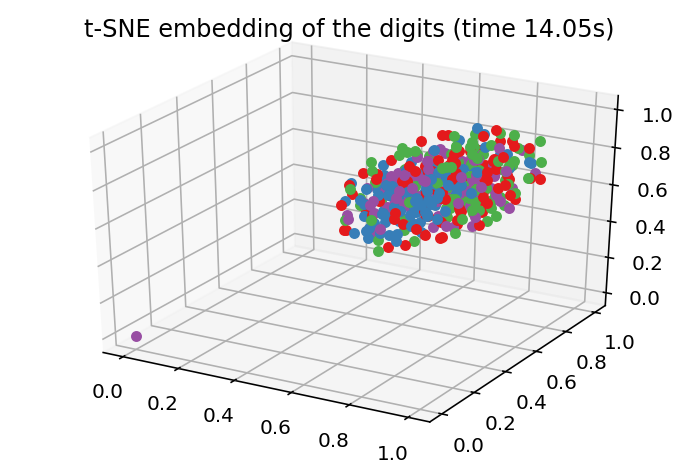

In [0]:

print('Computing t-SNE embedding')
tsne = TSNE(n_components=3, init='pca', random_state=0, n_iter=1000, early_exaggeration=12.0, perplexity=4)
t0 = time()
result = tsne.fit_transform(C4)
fig = plot_embedding(result, C5,
                     't-SNE embedding of the digits (time %.2fs)'
                     % (time() - t0))

plt.show(fig)

In [0]:
result[5]

array([ 0.47724858, -2.692271  ], dtype=float32)

In [0]:
a = 0
b = 0.5
c = 0.1
d = 1.1

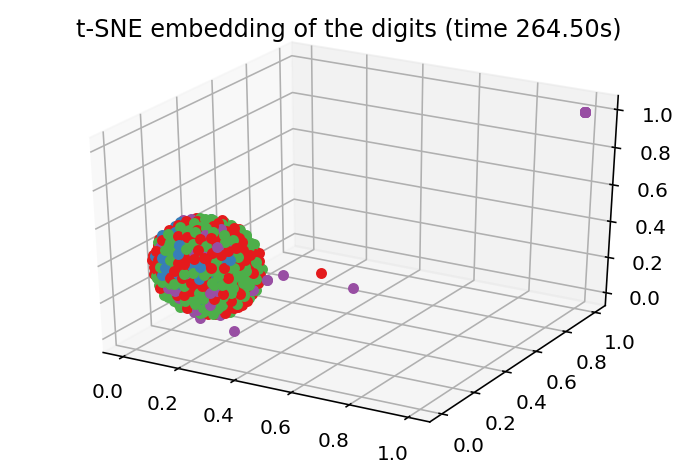

In [0]:
 fig = plot_embedding(result, C5,
                     't-SNE embedding of the digits (time %.2fs)'
                     % (time() - t0))
plt.xlim(a,b)
plt.ylim(c,d,1)
plt.xticks(np.linspace(a, b, 5))
plt.yticks(np.linspace(c, d, 5))

plt.show(fig)

In [0]:
result[0]

array([-2.433539 , -2.6290343], dtype=float32)

In [0]:
label.shape

(1083,)

In [0]:
a = 45
data=[]

for i, file in enumerate(glob.glob("/content/drive/My Drive/MusicBachViolin/*.mid")):
  data_temp = midi_to_matrix(file)
  for j in range(int(np.floor(data_temp[0,:].shape[0]/a))):
    data.append(data_temp[:,j:(j+a)])
  #data.append(data_temp)
    
midis_array = np.asarray(data)
    
midis_array = np.transpose(midis_array, (0, 2, 1)) 
midis_array = np.asarray(midis_array)
midis_array.shape 


midis_array = np.reshape(midis_array,(-1,128))
midis_array.shape

max_len = 15 # how many column will take account to predict next column.
step = 1 # step size.

previous_full = []
predicted_full = []

for i in range (0, midis_array.shape[0]-max_len, step):
    prev = midis_array[i:i+max_len,...] # take max_len column.
    pred = midis_array[i+max_len,...] # take (max_len)th column.
    previous_full.append(prev)
    predicted_full.append(pred)
    
    

In [0]:
previous_full = np.asarray(previous_full).astype('float64')
predicted_full = np.asarray (predicted_full).astype('float64')

In [0]:
num_of_sample, max_len, freq = previous_full.shape

print (previous_full.shape)
print (predicted_full.shape)

(24870, 15, 128)
(24870, 128)


In [0]:
from keras import layers
from keras import models
import keras
from keras.models import Model
import tensorflow as tf
from keras.layers.advanced_activations import *


midi_shape = (max_len, 128)

# 这部分返回一个张量
input_midi = keras.Input(midi_shape)

# 层的实例是可调用的，它以张量为参数，并且返回一个张量
#x = layers.Bidirectional(layers.LSTM(512, return_sequences=True, unit_forget_bias=True))(input_midi)
x = layers.Bidirectional(layers.LSTM(512, return_sequences=True, unit_forget_bias=True))(input_midi)
#1024是输出维度，input_midi是输入值
x = layers.LeakyReLU()(x)
x = layers.BatchNormalization() (x)
#x = layers.Dropout(0.3)(x)

x = layers.LSTM(128, unit_forget_bias=True)(x)
x = layers.LeakyReLU()(x)
x = layers.BatchNormalization()(x)


x = layers.Dense(128, activation='softmax')(x) 

model = Model(input_midi, x)
# optimizer = keras.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=0.0, amsgrad=False)
# optimizer = keras.optimizers.Nadam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-8, schedule_decay=0.004)
optimizer = keras.optimizers.SGD(lr=0.007)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

Using TensorFlow backend.
W0905 08:34:55.714381 140304395253632 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0905 08:34:55.717943 140304395253632 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0905 08:34:55.728028 140304395253632 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0905 08:34:57.891033 140304395253632 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:148: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instea

In [0]:
model.load_weights('/content/drive/My Drive/model3.h5')

In [0]:

import matplotlib.pyplot as plt

import random
import sys

epoch_total = 10000
batch_size = 10

for epoch in range(0, 20): # Train model with epoch_total 
    print('Epoch:', epoch)
    
    #model.load_weights('my_model_weights.h5') # load model's weights.
    model.fit(previous_full, predicted_full, batch_size=batch_size, epochs=1,
              shuffle=True) # Fit model for 1 iteration.
    
   # start_index = random.randint(0, len(midis_array)- max_len - 1)
    
    #generated_midi = midis_array[start_index: start_index + max_len]
    #model.save_weights('my_model_weights.h5')
    model.save("my_model.h5")
    
    start_index = random.randint(0, len(midis_array)- max_len - 1)
    midi_list = []
    for i in range(30):
        samples = midis_array[start_index+i: start_index+i+max_len]
        expanded_samples = np.expand_dims(samples, axis=0)
        preds = model.predict(expanded_samples, verbose=0)[0]
        preds = np.asarray(preds).astype('float64')
        midi_list.append(preds)    
    implot = plt.imshow(np.array(midi_list), cmap="gray")
    plt.show()    
        

In [0]:
midi_fulllist.shape

In [0]:
midi_fulllist = []
for j in range(500):  
  start_index = random.randint(0, len(midis_array)- max_len - 1)
  midi_list = []
  for i in range(48):
      samples = midis_array[start_index+i: start_index+i+max_len]
      expanded_samples = np.expand_dims(samples, axis=0)
      preds = model.predict(expanded_samples, verbose=0)[0]
      preds = np.asarray(preds).astype('float64')
      midi_list.append(preds)    
  midi_fulllist.append(np.array(midi_list))

In [0]:
start_index = random.randint(0, len(midis_array)- max_len - 1)
samples = midis_array[start_index+i: start_index+i+max_len]
midi_list = []
for i in range(64):
    expanded_samples = np.expand_dims(samples, axis=0)
    preds = model.predict(expanded_samples, verbose=0)[0]
    preds = np.asarray(preds).astype('float64')
    samples = np.vstack([samples, preds])
    samples = np.round(samples[1:16,:]*2)/2
    midi_list.append(preds)
a3 = np.vstack([ midis_array[start_index+i: start_index+i+max_len], np.array(midi_list)])

#implot = plt.imshow(a, cmap="gray")
#plt.show()   


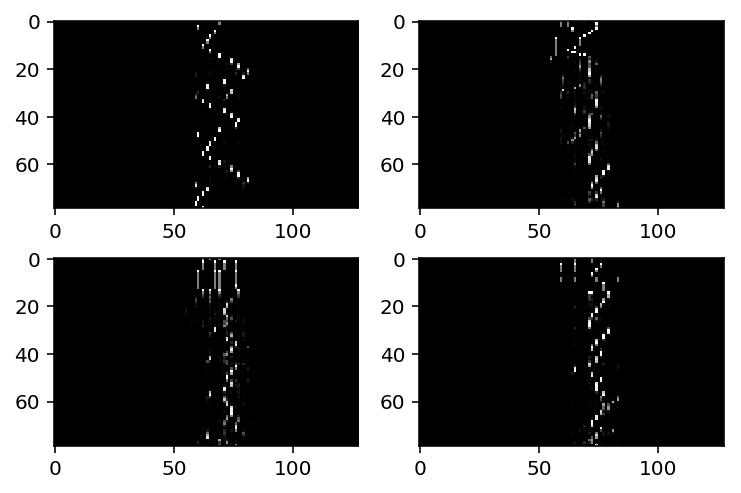

In [0]:
f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(a, cmap="gray")
axarr[0,1].imshow(a1, cmap="gray")
axarr[1,0].imshow(a2, cmap="gray")
axarr[1,1].imshow(a3, cmap="gray")



In [0]:
a.shape

(79, 128)

In [0]:
from google.colab import files
from midiutil.MidiFile import MIDIFile

matrix = a
# create your MIDI object
mf = MIDIFile(1)     # only 1 track
track = 0   # the only track

time = 0    # start at the beginning
mf.addTrackName(track, time, "Sample Track")
mf.addTempo(track, time, 120)

# add some notes
channel = 0
volume = 100
'''
pitch = 60           # C4 (middle C)
time = 0             # start on beat 0
duration = 1         # 1 beat long
mf.addNote(track, channel, pitch, time, duration, volume)

pitch = 64           # E4
time = 2             # start on beat 2
duration = 1         # 1 beat long
mf.addNote(track, channel, pitch, time, duration, volume)

pitch = 67           # G4
time = 4             # start on beat 4
duration = 1         # 1 beat long
mf.addNote(track, channel, pitch, time, duration, volume)
'''
for pitch in range(0,128):
  time = 0
  while time < 79:
    duration = 1
    if matrix[time, pitch]>=0.7:
      if time <78:
        while (matrix[time+duration, pitch]>=0.25)*(matrix[time+duration, pitch]<0.7)*(time+duration < 78):
            duration  = duration+1            
      mf.addNote(track, channel, pitch, time, duration, volume)
    if (matrix[time, pitch]>= 0.25)*(matrix[time-1, pitch]<0.25):  
      if time <78:
        while (matrix[time+duration, pitch]>=0.25)*(matrix[time+duration, pitch]<0.7)*(time+duration < 78):
            duration  = duration+1            
      mf.addNote(track, channel, pitch, time, duration, volume)      
    
    time +=1
    


# write it to disk
with open("output4.mid", 'wb') as outf:
    mf.writeFile(outf)  
    
for file in os.listdir(os.getcwd()):
    if file.endswith("output4.mid"):
      files.download(file)    